In [1]:
pip install -qU langchain umap-learn scikit-learn langchain_community tiktoken langchain-openai langchainhub chromadb langchain-anthropic

Note: you may need to restart the kernel to use updated packages.


<function matplotlib.pyplot.show(close=None, block=None)>

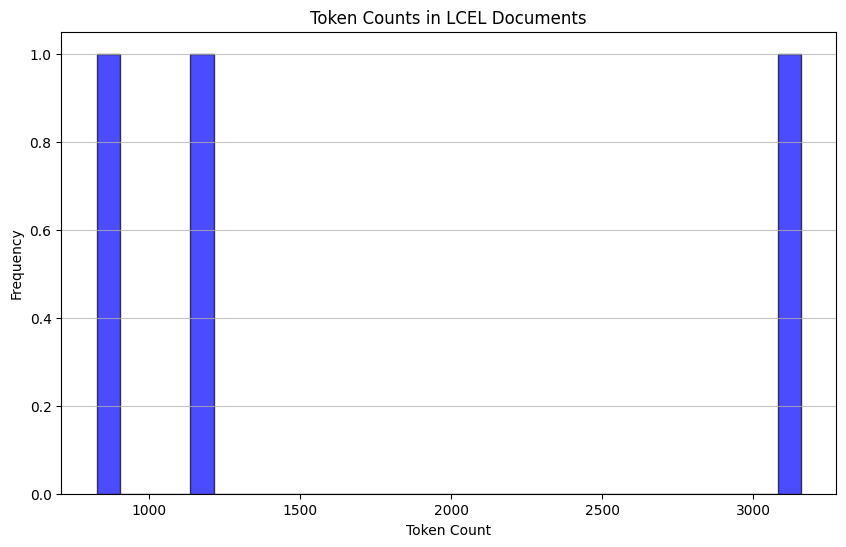

In [29]:
from langchain_community.document_loaders.recursive_url_loader import RecursiveUrlLoader
from bs4 import BeautifulSoup as Soup
import tiktoken
import matplotlib.pyplot as plt


def num_tokens_from_string(string: str, encoding_name: str) -> int:
    # 주어진 문자열에서 토큰의 개수를 반환합니다.
    encoding = tiktoken.get_encoding(encoding_name)
    num_tokens = len(encoding.encode(string))
    return num_tokens


# LCEL 문서 로드
url = "https://python.langchain.com/docs/expression_language/"
loader = RecursiveUrlLoader(
    url=url, max_depth=20, extractor=lambda x: Soup(x, "html.parser").text
)
docs = loader.load()

# PydanticOutputParser를 사용한 LCEL 문서 로드 (기본 LCEL 문서 외부)
url = "https://python.langchain.com/docs/modules/model_io/output_parsers/quick_start"
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs_pydantic = loader.load()

# Self Query를 사용한 LCEL 문서 로드 (기본 LCEL 문서 외부)
url = "https://python.langchain.com/docs/modules/data_connection/retrievers/self_query/"
loader = RecursiveUrlLoader(
    url=url, max_depth=1, extractor=lambda x: Soup(x, "html.parser").text
)
docs_sq = loader.load()

# 문서 텍스트
docs.extend([*docs_pydantic, *docs_sq])
docs_texts = [d.page_content for d in docs]

# 각 문서에 대한 토큰 수 계산
counts = [num_tokens_from_string(d, "cl100k_base") for d in docs_texts]

# 토큰 수의 히스토그램을 그립니다.
plt.figure(figsize=(10, 6))
plt.hist(counts, bins=30, color="blue", edgecolor="black", alpha=0.7)
plt.title("Token Counts in LCEL Documents")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)

# 히스토그램을 표시합니다.
plt.show

In [30]:
# 문서 텍스트를 연결합니다.
# 문서를 출처 메타데이터 기준으로 정렬합니다.
d_sorted = sorted(docs, key=lambda x: x.metadata["source"])
d_reversed = list(reversed(d_sorted))  # 정렬된 문서를 역순으로 배열합니다.
concatenated_content = "\n\n\n --- \n\n\n".join(
    [
        # 역순으로 배열된 문서의 내용을 연결합니다.
        doc.page_content
        for doc in d_reversed
    ]
)
print(
    "Num tokens in all context: %s"  # 모든 문맥에서의 토큰 수를 출력합니다.
    % num_tokens_from_string(concatenated_content, "cl100k_base")
)

Num tokens in all context: 5175


In [31]:
# 텍스트 분할을 위한 코드
from langchain_text_splitters import RecursiveCharacterTextSplitter

chunk_size_tok = 2000  # 토큰의 청크 크기를 설정합니다.
# 재귀적 문자 텍스트 분할기를 초기화합니다. 토큰 인코더를 사용하여 청크 크기와 중복을 설정합니다.
text_splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=chunk_size_tok, chunk_overlap=0
)
texts_split = text_splitter.split_text(
    concatenated_content
)  # 주어진 텍스트를 분할합니다.

In [32]:
from dotenv import load_dotenv
import os
from langchain_teddynote import logging
print(load_dotenv())
print(f"[API KEY]\n{os.environ['OPENAI_API_KEY'][:-15]}" + "*" * 15)
logging.langsmith("yong_12")



True
[API KEY]
sk-None-FZcW7iODyxjiAh7qYSpIT3BlbkFJyqnfN***************
LangSmith 추적을 시작합니다.
[프로젝트명]
yong_12


In [34]:
from langchain_openai import OpenAIEmbeddings
from langchain.embeddings import CacheBackedEmbeddings
from langchain.storage import LocalFileStore
store = LocalFileStore("./cache/")

# embeddings 인스턴스를 생성합니다.
embd = OpenAIEmbeddings(model="text-embedding-3-small", disallowed_special=())

cached_embeddings = CacheBackedEmbeddings.from_bytes_store(
    embd, store, namespace=embd.model
)

In [35]:
from langchain_anthropic import ChatAnthropic
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain.callbacks.base import BaseCallbackHandler


class StreamCallback(BaseCallbackHandler):
    def on_llm_new_token(self, token: str, **kwargs):
        print(token, end="", flush=True)


model = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    streaming=True,
    callbacks=[StreamCallback()],
)

# ChatAnthropic 모델을 초기화합니다. 온도는 0으로 설정하고, 모델은 "claude-3-opus-20240229"를 사용합니다.
# model = ChatAnthropic(temperature=0, model="claude-3-opus-20240229")

In [36]:
from typing import Dict, List, Optional, Tuple

import numpy as np
import pandas as pd
import umap
from langchain.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from sklearn.mixture import GaussianMixture

RANDOM_SEED = 42  # 재현성을 위한 고정된 시드 값

### --- 위의 인용된 코드에서 주석과 문서화를 추가함 --- ###


def global_cluster_embeddings(
    embeddings: np.ndarray,
    dim: int,
    n_neighbors: Optional[int] = None,
    metric: str = "cosine",
) -> np.ndarray:
    """
    UMAP을 사용하여 임베딩의 전역 차원 축소를 수행합니다.

    매개변수:
    - embeddings: numpy 배열로 된 입력 임베딩.
    - dim: 축소된 공간의 목표 차원.
    - n_neighbors: 선택 사항; 각 점을 고려할 이웃의 수.
                   제공되지 않으면 임베딩 수의 제곱근으로 기본 설정됩니다.
    - metric: UMAP에 사용할 거리 측정 기준.

    반환값:
    - 지정된 차원으로 축소된 임베딩의 numpy 배열.
    """
    if n_neighbors is None:
        n_neighbors = int((len(embeddings) - 1) ** 0.5)
    return umap.UMAP(
        n_neighbors=n_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)

In [37]:
def local_cluster_embeddings(
    embeddings: np.ndarray, dim: int, num_neighbors: int = 10, metric: str = "cosine"
) -> np.ndarray:
    """
    임베딩에 대해 지역 차원 축소를 수행합니다. 이는 일반적으로 전역 클러스터링 이후에 사용됩니다.

    매개변수:
    - embeddings: numpy 배열로서의 입력 임베딩.
    - dim: 축소된 공간의 목표 차원 수.
    - num_neighbors: 각 점에 대해 고려할 이웃의 수.
    - metric: UMAP에 사용할 거리 측정 기준.

    반환값:
    - 지정된 차원으로 축소된 임베딩의 numpy 배열.
    """
    return umap.UMAP(
        n_neighbors=num_neighbors, n_components=dim, metric=metric
    ).fit_transform(embeddings)

In [38]:
def get_optimal_clusters(
    embeddings: np.ndarray, max_clusters: int = 50, random_state: int = RANDOM_SEED
) -> int:
    """
    가우시안 혼합 모델(Gaussian Mixture Model)을 사용하여 베이지안 정보 기준(BIC)을 통해 최적의 클러스터 수를 결정합니다.

    매개변수:
    - embeddings: numpy 배열로서의 입력 임베딩.
    - max_clusters: 고려할 최대 클러스터 수.
    - random_state: 재현성을 위한 시드.

    반환값:
    - 발견된 최적의 클러스터 수를 나타내는 정수.
    """
    max_clusters = min(
        max_clusters, len(embeddings)
    )  # 최대 클러스터 수와 임베딩의 길이 중 작은 값을 최대 클러스터 수로 설정
    n_clusters = np.arange(1, max_clusters)  # 1부터 최대 클러스터 수까지의 범위를 생성
    bics = []  # BIC 점수를 저장할 리스트
    for n in n_clusters:  # 각 클러스터 수에 대해 반복
        gm = GaussianMixture(
            n_components=n, random_state=random_state
        )  # 가우시안 혼합 모델 초기화
        gm.fit(embeddings)  # 임베딩에 대해 모델 학습
        bics.append(gm.bic(embeddings))  # 학습된 모델의 BIC 점수를 리스트에 추가
    return n_clusters[np.argmin(bics)]  # BIC 점수가 가장 낮은 클러스터 수를 반환

In [39]:
def GMM_cluster(embeddings: np.ndarray, threshold: float, random_state: int = 0):
    """
    확률 임계값을 기반으로 가우시안 혼합 모델(GMM)을 사용하여 임베딩을 클러스터링합니다.

    매개변수:
    - embeddings: numpy 배열로서의 입력 임베딩.
    - threshold: 임베딩을 클러스터에 할당하기 위한 확률 임계값.
    - random_state: 재현성을 위한 시드.

    반환값:
    - 클러스터 레이블과 결정된 클러스터 수를 포함하는 튜플.
    """
    n_clusters = get_optimal_clusters(embeddings)  # 최적의 클러스터 수를 구합니다.
    # 가우시안 혼합 모델을 초기화합니다.
    gm = GaussianMixture(n_components=n_clusters, random_state=random_state)
    gm.fit(embeddings)  # 임베딩에 대해 모델을 학습합니다.
    probs = gm.predict_proba(
        embeddings
    )  # 임베딩이 각 클러스터에 속할 확률을 예측합니다.
    # 임계값을 초과하는 확률을 가진 클러스터를 레이블로 선택합니다.
    labels = [np.where(prob > threshold)[0] for prob in probs]
    return labels, n_clusters  # 레이블과 클러스터 수를 반환합니다.

In [40]:
def perform_clustering(
    embeddings: np.ndarray,
    dim: int,
    threshold: float,
) -> List[np.ndarray]:
    """
    임베딩에 대해 차원 축소, 가우시안 혼합 모델을 사용한 클러스터링, 각 글로벌 클러스터 내에서의 로컬 클러스터링을 순서대로 수행합니다.

    매개변수:
    - embeddings: numpy 배열로 된 입력 임베딩입니다.
    - dim: UMAP 축소를 위한 목표 차원입니다.
    - threshold: GMM에서 임베딩을 클러스터에 할당하기 위한 확률 임계값입니다.

    반환값:
    - 각 임베딩의 클러스터 ID를 포함하는 numpy 배열의 리스트입니다.
    """
    if len(embeddings) <= dim + 1:
        # 데이터가 충분하지 않을 때 클러스터링을 피합니다.
        return [np.array([0]) for _ in range(len(embeddings))]

    # 글로벌 차원 축소
    reduced_embeddings_global = global_cluster_embeddings(embeddings, dim)
    # 글로벌 클러스터링
    global_clusters, n_global_clusters = GMM_cluster(
        reduced_embeddings_global, threshold
    )

    all_local_clusters = [np.array([]) for _ in range(len(embeddings))]
    total_clusters = 0

    # 각 글로벌 클러스터를 순회하며 로컬 클러스터링 수행
    for i in range(n_global_clusters):
        # 현재 글로벌 클러스터에 속하는 임베딩 추출
        global_cluster_embeddings_ = embeddings[
            np.array([i in gc for gc in global_clusters])
        ]

        if len(global_cluster_embeddings_) == 0:
            continue
        if len(global_cluster_embeddings_) <= dim + 1:
            # 작은 클러스터는 직접 할당으로 처리
            local_clusters = [np.array([0]) for _ in global_cluster_embeddings_]
            n_local_clusters = 1
        else:
            # 로컬 차원 축소 및 클러스터링
            reduced_embeddings_local = local_cluster_embeddings(
                global_cluster_embeddings_, dim
            )
            local_clusters, n_local_clusters = GMM_cluster(
                reduced_embeddings_local, threshold
            )

        # 로컬 클러스터 ID 할당, 이미 처리된 총 클러스터 수를 조정
        for j in range(n_local_clusters):
            local_cluster_embeddings_ = global_cluster_embeddings_[
                np.array([j in lc for lc in local_clusters])
            ]
            indices = np.where(
                (embeddings == local_cluster_embeddings_[:, None]).all(-1)
            )[1]
            for idx in indices:
                all_local_clusters[idx] = np.append(
                    all_local_clusters[idx], j + total_clusters
                )

        total_clusters += n_local_clusters

    return all_local_clusters

In [41]:
def embed(texts):
    # 텍스트 문서 목록에 대한 임베딩을 생성합니다.
    #
    # 이 함수는 `embd` 객체가 존재한다고 가정하며, 이 객체는 텍스트 목록을 받아 그 임베딩을 반환하는 `embed_documents` 메소드를 가지고 있습니다.
    #
    # 매개변수:
    # - texts: List[str], 임베딩할 텍스트 문서의 목록입니다.
    #
    # 반환값:
    # - numpy.ndarray: 주어진 텍스트 문서들에 대한 임베딩 배열입니다.
    text_embeddings = embd.embed_documents(
        texts
    )  # 텍스트 문서들의 임베딩을 생성합니다.
    text_embeddings_np = np.array(text_embeddings)  # 임베딩을 numpy 배열로 변환합니다.
    return text_embeddings_np  # 임베딩된 numpy 배열을 반환합니다.

In [42]:
def embed_cluster_texts(texts):
    """
    텍스트 목록을 임베딩하고 클러스터링하여, 텍스트, 그들의 임베딩, 그리고 클러스터 라벨이 포함된 DataFrame을 반환합니다.

    이 함수는 임베딩 생성과 클러스터링을 단일 단계로 결합합니다. 임베딩에 대해 클러스터링을 수행하는 `perform_clustering` 함수의 사전 정의된 존재를 가정합니다.

    매개변수:
    - texts: List[str], 처리될 텍스트 문서의 목록입니다.

    반환값:
    - pandas.DataFrame: 원본 텍스트, 그들의 임베딩, 그리고 할당된 클러스터 라벨이 포함된 DataFrame입니다.
    """
    text_embeddings_np = embed(texts)  # 임베딩 생성
    cluster_labels = perform_clustering(
        text_embeddings_np, 10, 0.1
    )  # 임베딩에 대해 클러스터링 수행
    df = pd.DataFrame()  # 결과를 저장할 DataFrame 초기화
    df["text"] = texts  # 원본 텍스트 저장
    df["embd"] = list(text_embeddings_np)  # DataFrame에 리스트로 임베딩 저장
    df["cluster"] = cluster_labels  # 클러스터 라벨 저장
    return df

In [43]:
def fmt_txt(df: pd.DataFrame) -> str:
    """
    DataFrame에 있는 텍스트 문서를 단일 문자열로 포맷합니다.

    매개변수:
    - df: 'text' 열에 포맷할 텍스트 문서가 포함된 DataFrame.

    반환값:
    - 모든 텍스트 문서가 특정 구분자로 결합된 단일 문자열.
    """
    unique_txt = df["text"].tolist()  # 'text' 열의 모든 텍스트를 리스트로 변환
    return "--- --- \n --- --- ".join(
        unique_txt
    )  # 텍스트 문서들을 특정 구분자로 결합하여 반환

In [44]:
def embed_cluster_summarize_texts(
    texts: List[str], level: int
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    텍스트 목록에 대해 임베딩, 클러스터링 및 요약을 수행합니다. 이 함수는 먼저 텍스트에 대한 임베딩을 생성하고,
    유사성을 기반으로 클러스터링을 수행한 다음, 클러스터 할당을 확장하여 처리를 용이하게 하고 각 클러스터 내의 내용을 요약합니다.

    매개변수:
    - texts: 처리할 텍스트 문서 목록입니다.
    - level: 처리의 깊이나 세부 사항을 정의할 수 있는 정수 매개변수입니다.

    반환값:
    - 두 개의 데이터프레임을 포함하는 튜플:
      1. 첫 번째 데이터프레임(`df_clusters`)은 원본 텍스트, 그들의 임베딩, 그리고 클러스터 할당을 포함합니다.
      2. 두 번째 데이터프레임(`df_summary`)은 각 클러스터에 대한 요약, 지정된 세부 수준, 그리고 클러스터 식별자를 포함합니다.
    """

    # 텍스트를 임베딩하고 클러스터링하여 'text', 'embd', 'cluster' 열이 있는 데이터프레임을 생성합니다.
    df_clusters = embed_cluster_texts(texts)

    # 클러스터를 쉽게 조작하기 위해 데이터프레임을 확장할 준비를 합니다.
    expanded_list = []

    # 데이터프레임 항목을 문서-클러스터 쌍으로 확장하여 처리를 간단하게 합니다.
    for index, row in df_clusters.iterrows():
        for cluster in row["cluster"]:
            expanded_list.append(
                {"text": row["text"], "embd": row["embd"], "cluster": cluster}
            )

    # 확장된 목록에서 새 데이터프레임을 생성합니다.
    expanded_df = pd.DataFrame(expanded_list)

    # 처리를 위해 고유한 클러스터 식별자를 검색합니다.
    all_clusters = expanded_df["cluster"].unique()

    print(f"--Generated {len(all_clusters)} clusters--")

    # 요약
    template = """여기 LangChain 표현 언어 문서의 하위 집합이 있습니다.
    
    LangChain 표현 언어는 LangChain에서 체인을 구성하는 방법을 제공합니다.
    
    제공된 문서의 자세한 요약을 제공하십시오.
    
    문서:
    {context}
    """
    prompt = ChatPromptTemplate.from_template(template)
    chain = prompt | model | StrOutputParser()

    # 각 클러스터 내의 텍스트를 요약을 위해 포맷팅합니다.
    summaries = []
    for i in all_clusters:
        df_cluster = expanded_df[expanded_df["cluster"] == i]
        formatted_txt = fmt_txt(df_cluster)
        summaries.append(chain.invoke({"context": formatted_txt}))

    # 요약, 해당 클러스터 및 레벨을 저장할 데이터프레임을 생성합니다.
    df_summary = pd.DataFrame(
        {
            "summaries": summaries,
            "level": [level] * len(summaries),
            "cluster": list(all_clusters),
        }
    )

    return df_clusters, df_summary

In [45]:
def recursive_embed_cluster_summarize(
    texts: List[str], level: int = 1, n_levels: int = 3
) -> Dict[int, Tuple[pd.DataFrame, pd.DataFrame]]:
    """
    지정된 레벨까지 또는 고유 클러스터의 수가 1이 될 때까지 텍스트를 재귀적으로 임베딩, 클러스터링, 요약하여
    각 레벨에서의 결과를 저장합니다.

    매개변수:
    - texts: List[str], 처리할 텍스트들.
    - level: int, 현재 재귀 레벨 (1에서 시작).
    - n_levels: int, 재귀의 최대 깊이.

    반환값:
    - Dict[int, Tuple[pd.DataFrame, pd.DataFrame]], 재귀 레벨을 키로 하고 해당 레벨에서의 클러스터 DataFrame과 요약 DataFrame을 포함하는 튜플을 값으로 하는 사전.
    """
    results = {}  # 각 레벨에서의 결과를 저장할 사전

    # 현재 레벨에 대해 임베딩, 클러스터링, 요약 수행
    df_clusters, df_summary = embed_cluster_summarize_texts(texts, level)

    # 현재 레벨의 결과 저장
    results[level] = (df_clusters, df_summary)

    # 추가 재귀가 가능하고 의미가 있는지 결정
    unique_clusters = df_summary["cluster"].nunique()
    if level < n_levels and unique_clusters > 1:
        # 다음 레벨의 재귀 입력 텍스트로 요약 사용
        new_texts = df_summary["summaries"].tolist()
        next_level_results = recursive_embed_cluster_summarize(
            new_texts, level + 1, n_levels
        )

        # 다음 레벨의 결과를 현재 결과 사전에 병합
        results.update(next_level_results)

    return results

In [46]:
# 전체 문서의 개수
len(docs_texts)

3

In [47]:
# 트리 구축
leaf_texts = docs_texts  # 문서 텍스트를 리프 텍스트로 설정
results = recursive_embed_cluster_summarize(
    leaf_texts, level=1, n_levels=3
)  # 재귀적으로 임베딩, 클러스터링 및 요약을 수행하여 결과를 얻음

--Generated 1 clusters--
LangChain 표현 언어(LangChain Expression Language, LCEL)는 LangChain에서 체인을 구성하는 방법을 제공하는 선언적 언어입니다. LCEL은 프로토타입을 코드 변경 없이 바로 프로덕션에 배포할 수 있도록 설계되었습니다. LCEL을 사용하면 간단한 "프롬프트 + LLM" 체인부터 수백 단계의 복잡한 체인까지 구성할 수 있습니다. 주요 기능은 다음과 같습니다:

1. **스트리밍 지원**: LCEL로 체인을 구성하면 첫 번째 토큰이 출력될 때까지의 시간을 최소화할 수 있습니다. 예를 들어, LLM에서 스트리밍 출력 파서로 토큰을 스트리밍하여 점진적으로 파싱된 출력을 받을 수 있습니다.

2. **비동기 지원**: LCEL로 구성된 체인은 동기 및 비동기 API를 모두 지원합니다. 이는 프로토타입과 프로덕션에서 동일한 코드를 사용할 수 있게 하며, 높은 성능과 동시 요청 처리 능력을 제공합니다.

3. **병렬 실행 최적화**: LCEL 체인의 병렬 실행 가능한 단계는 자동으로 병렬 처리되어 지연 시간을 최소화합니다.

4. **재시도 및 폴백**: LCEL 체인의 모든 부분에 대해 재시도 및 폴백을 구성할 수 있습니다. 이는 체인의 신뢰성을 높이는 데 유용하며, 스트리밍 지원도 추가될 예정입니다.

5. **중간 결과 접근**: 복잡한 체인의 경우 최종 출력이 생성되기 전에 중간 단계의 결과에 접근할 수 있습니다. 이는 사용자에게 진행 상황을 알리거나 디버깅에 유용합니다.

6. **입력 및 출력 스키마**: LCEL 체인은 Pydantic 및 JSONSchema 스키마를 통해 입력 및 출력을 검증할 수 있습니다. 이는 LangServe의 중요한 부분입니다.

7. **LangSmith 추적 통합**: 체인이 복잡해질수록 각 단계에서 무슨 일이 일어나는지 이해하는 것이 중요합니다. LCEL은 모든 단계를 LangSmith에 자동으로 기록하여 최대한의 가시성과 디버깅 가능성을 제공합

In [56]:
from langchain_community.vectorstores import FAISS

# leaf_texts를 복사하여 all_texts를 초기화합니다.
all_texts = leaf_texts.copy()

# 각 레벨의 요약을 추출하여 all_texts에 추가하기 위해 결과를 순회합니다.
for level in sorted(results.keys()):
    # 현재 레벨의 DataFrame에서 요약을 추출합니다.
    summaries = results[level][1]["summaries"].tolist()
    # 현재 레벨의 요약을 all_texts에 추가합니다.
    all_texts.extend(summaries)

# 이제 all_texts를 사용하여 FAISS vectorstore를 구축합니다.
vectorstore = FAISS.from_texts(texts=all_texts, embedding=embd)

In [67]:
import faiss

# FAISS.load_local 함수 확인
print(dir(faiss))


['APPROX_TOPK_BUCKETS_B16_D2', 'APPROX_TOPK_BUCKETS_B32_D2', 'APPROX_TOPK_BUCKETS_B8_D2', 'APPROX_TOPK_BUCKETS_B8_D3', 'AdditiveCoarseQuantizer', 'AdditiveQuantizer', 'AlignedTableFloat32', 'AlignedTableUint16', 'AlignedTableUint8', 'AlignedTable_to_array', 'ArrayInvertedLists', 'AutoTuneCriterion', 'BinaryInvertedListScanner', 'BitstringReader', 'BitstringWriter', 'BlockInvertedLists', 'BufferList', 'BufferedIOReader', 'BufferedIOWriter', 'ByteVector', 'ByteVectorVector', 'CMax_float_partition_fuzzy', 'CMax_uint16_partition_fuzzy', 'CMin_float_partition_fuzzy', 'CMin_uint16_partition_fuzzy', 'CenteringTransform', 'CharVector', 'Cloner', 'Clustering', 'Clustering1D', 'ClusteringIterationStats', 'ClusteringIterationStatsVector', 'ClusteringParameters', 'CodePacker', 'CodePackerFlat', 'CodeSet', 'CombinerRangeKNNfloat', 'CombinerRangeKNNint16', 'ComputeCodesAddCentroidsLUT0MemoryPool', 'ComputeCodesAddCentroidsLUT1MemoryPool', 'ConcatenatedInvertedLists', 'DirectMap', 'DirectMapAdd', 'Di

In [68]:
import os
import pickle
DB_INDEX = "RAPTOR"
allow_dangerous_deserialization = True
# 로컬에 FAISS DB 인덱스가 이미 존재하는지 확인하고, 그렇다면 로드하여 vectorstore와 병합한 후 저장합니다.
if os.path.exists(DB_INDEX):
    local_index = FAISS.load_local(DB_INDEX, embd)
    local_index.merge_from(vectorstore)
    local_index.save_local(DB_INDEX)
else:
    vectorstore.save_local(folder_path=DB_INDEX)

ValueError: The de-serialization relies loading a pickle file. Pickle files can be modified to deliver a malicious payload that results in execution of arbitrary code on your machine.You will need to set `allow_dangerous_deserialization` to `True` to enable deserialization. If you do this, make sure that you trust the source of the data. For example, if you are loading a file that you created, and know that no one else has modified the file, then this is safe to do. Do not set this to `True` if you are loading a file from an untrusted source (e.g., some random site on the internet.).

In [60]:
retriever = vectorstore.as_retriever()

In [61]:
from langchain import hub
from langchain_core.runnables import RunnablePassthrough

# 프롬프트 생성
prompt = hub.pull("rlm/rag-prompt")

# 문서 포스트 프로세싱


def format_docs(docs):
    # 문서의 페이지 내용을 이어붙여 반환합니다.
    return "\n\n".join(doc.page_content for doc in docs)


# RAG 체인 정의
rag_chain = (
    # 검색 결과를 포맷팅하고 질문을 처리합니다.
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt  # 프롬프트를 적용합니다.
    | model  # 모델을 적용합니다.
    | StrOutputParser()  # 문자열 출력 파서를 적용합니다.
)

In [62]:
_ = rag_chain.invoke("전체 문서의 핵심 주제에 대해 설명해주세요.")

전체 문서의 핵심 주제는 LangChain Expression Language (LCEL)입니다. LCEL은 LangChain에서 체인을 구성하는 선언적 언어로, 프로토타입을 코드 변경 없이 바로 프로덕션에 배포할 수 있도록 설계되었습니다. LCEL은 스트리밍 지원, 비동기 지원, 병렬 실행 최적화, 재시도 및 폴백, 중간 결과 접근, 입력 및 출력 스키마 검증, LangSmith 추적 통합, LangServe 배포 통합 등의 기능을 제공합니다.

In [63]:
_ = rag_chain.invoke("PydanticOutputParser 을 활용한 예시 코드를 작성해 주세요.")

```python
from langchain.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field, validator
from langchain_openai import OpenAI

# Define your desired data structure.
class Joke(BaseModel):
    setup: str = Field(description="question to set up a joke")
    punchline: str = Field(description="answer to resolve the joke")

    @validator("setup")
    def question_ends_with_question_mark(cls, field):
        if field[-1] != "?":
            raise ValueError("Badly formed question!")
        return field

# Set up a parser and inject instructions into the prompt template.
parser = PydanticOutputParser(pydantic_object=Joke)
prompt = PromptTemplate(
    template="Answer the user query.\n{format_instructions}\n{query}\n",
    input_variables=["query"],
    partial_variables={"format_instructions": parser.get_format_instructions()},
)

# Initialize the model and create a chain.
model = OpenAI(model_na

In [64]:
_ = rag_chain.invoke("self-querying 방법과 예시 코드를 작성해 주세요.")

Self-querying 방법은 자연어 쿼리를 구조화된 쿼리로 변환하여 벡터 스토어에 적용하는 것입니다. 예시 코드는 다음과 같습니다:

```python
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_openai import OpenAIEmbeddings
from langchain.chains.query_constructor.base import AttributeInfo
from langchain.retrievers.self_query.base import SelfQueryRetriever
from langchain_openai import ChatOpenAI

# 문서 생성
docs = [
    Document(page_content="A bunch of scientists bring back dinosaurs and mayhem breaks loose", metadata={"year": 1993, "rating": 7.7, "genre": "science fiction"}),
    Document(page_content="Leo DiCaprio gets lost in a dream within a dream within a dream within a ...", metadata={"year": 2010, "director": "Christopher Nolan", "rating": 8.2}),
    # 추가 문서들...
]

# 벡터 스토어 생성
vectorstore = Chroma.from_documents(docs, OpenAIEmbeddings())

# 메타데이터 필드 정보 설정
metadata_field_info = [
    AttributeInfo(name="genre", description="The genre of the movie. One of ['science fiction', 'comedy', 'drama'